#  A Bayesian Exact Test

Here we (re)-develop a Bayesian approach to Fisher's exact test following the example from Andrew Gelman's [blog post](https://andrewgelman.com/2009/10/13/what_is_the_bay/) and compare it to the latter. Fisher's exact test is ironically, hardly every suitable ([Gelman 2003](http://www.stat.columbia.edu/~gelman/research/published/isr.pdf)) in observational studies so it makes sense to look for alternatives (because we usually don't have fixed margins).

We use Fisher's *Lady tasting tea* data that consists of the number of times said lady guessed whether tea or milk was *first* added to a cup of tea. Fisher porposed to serve eight cups of tea, 4 of each variety, in random order. For our simulation the lady was able to correctly identify the first ingredient 3 times each. Thus we have $y_{tea} = 3$ and $y_{milk} = 3$ which are the numbers of times the guesses that it was tea or milk, respectively, was correct in a total of $n_{tea} = n_{milk} = 4$ trials (these are the margins and here they are *indeed* fixed).

In [1]:
y_tea <- 3
y_milk <- 1
n_tea <- n_milk <- 4

This gives us a $2 \times 2$ contingency table, where the rows are the guesses and the columns are the different teas served.

In [2]:
tea_data <- matrix(
    c(y_tea, y_milk, n_tea - y_tea, n_milk - y_milk),
    ncol = 2,
    dimnames = list("guess" = c("tea", "milk"),
                    "given" = c("tea", "milk")))
print(tea_data)

      given
guess  tea milk
  tea    3    1
  milk   1    3


We test whether *given* and *guess* are independent of each other, i.e. a null hypothesis of no association against an alternative that we have a *positive* association, since the lady claimed she can predict it from tasting the tea alone.

In [3]:
fisher.test(tea_data, alternative = "greater")


	Fisher's Exact Test for Count Data

data:  tea_data
p-value = 0.2429
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 0.3135693       Inf
sample estimates:
odds ratio 
  6.408309 


For a significance level of $\alpha = 0.10$ we wouldnt reject the null here. Let's compare this to a Bayesian approach. According to Gelman we would assume a Binomial likelihood $\text{Binom}(n, \theta)$ for both the numbers $y_{tea}$ and $y_{milk}$:

$$
y \sim \text{Binom}(n, \theta)
$$

We use a prior for the success probabilities. The conjugate prior for this is the Beta, which leads to:

$$
\theta \sim \text{Beta}(a, b)
$$

Computing the posterior for these can then be done analytically. We use probabilistic programming language, `greta`, instead to do the sampling.

In [4]:
library(greta)
library(ggplot2)
library(ggthemes)

options(repr.plot.width=5, repr.plot.height=3)
set.seed(23)


Attaching package: ‘greta’

The following objects are masked from ‘package:stats’:

    binomial, poisson

The following objects are masked from ‘package:base’:

    %*%, backsolve, beta, colMeans, colSums, diag, forwardsolve, gamma,
    rowMeans, rowSums, sweep



We use priors with hyperparameters $a=b=0.5$ which is [Jeffreys prior](https://en.wikipedia.org/wiki/Jeffreys_prior) and set up the respective models. Let's plot Jeffreys prior first.

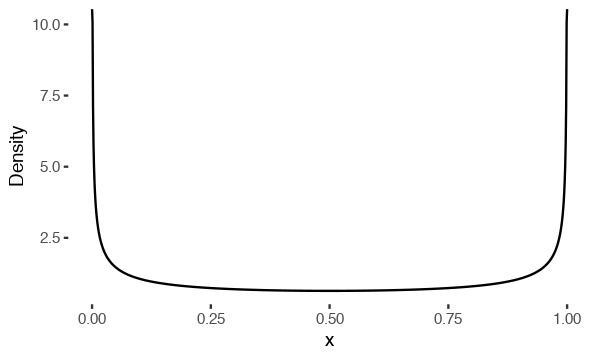

In [5]:
x <- seq(0, 1, length.out = 1000)
ggplot(data.frame(x=x, prob=dbeta(x, shape1 = 0.5, shape2 = 0.5))) +
    geom_line(aes(x=x, y=prob)) +
    scale_y_continuous("Density") +
    ggthemes::theme_tufte()

So, in this case the Jeffreys prior has most density on the tails. We use `greta` to set up the model (`stan`, `pymc3`, etc. does the same trick apparently. We could also compute it analytically).

In [6]:
theta_tea <- greta::beta(.5, .5)
theta_milk <- greta::beta(.5, .5)

distribution(y_tea) <- greta::binomial(n_tea, theta_tea)
distribution(y_milk) <- greta::binomial(n_milk, theta_milk)

Then we sample from the model. We compute 1000 posterior samples for both $\theta_{tea}$ and $\theta_{milk}$.

In [7]:
m <- greta::model(theta_tea, theta_milk)
samples <- as.matrix(greta::mcmc(m))

    warmup ====================================   100/100 | eta:  0s          
  sampling ==================================== 1000/1000 | eta:  0s          


If the lady is indeed able to reliably guess the tea, we would assume that the difference of posterior $\theta_{tea} - \theta_{milk}$  samples primarily positive.

In [8]:
theta_1_samples <- samples[ ,1]
theta_2_samples <- samples[ ,2]
thetas <- data.frame(Theta=theta_1_samples - theta_2_samples)

Let's plot these differences:

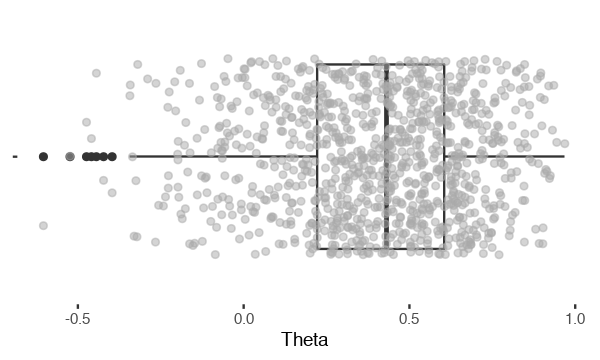

In [9]:
ggplot(thetas) +
    geom_boxplot(aes(x="", y=Theta)) +
    geom_jitter(aes(x="", y=Theta), col="darkgrey", alpha=0.5) +
    xlab(NULL) +
    coord_flip() +
    theme_tufte()

Most of the differences are indeed positive, so the lady seems to actually know her tea! Computing the posterior 95%-quantiles gives us

In [10]:
quants <- quantile(thetas$Theta, c(0.025, 0.5, 0.975))
print(quants)

      2.5%        50%      97.5% 
-0.2051205  0.4300661  0.8612803 


These are fairly thick however.In order to compute the probability $P[\theta_{tea} > \theta_{milk}]$ we use the average:

$$
\frac{1}{n} \sum_i I(\theta_{tea}^{(i)} - \theta_{milk}^{(i)})
$$


In [11]:
print(mean(thetas$Theta > 0))

[1] 0.9


So there is a 90% probability that the Lady knows here tea. Let's also look at the posterior samples to compare them with the prior.

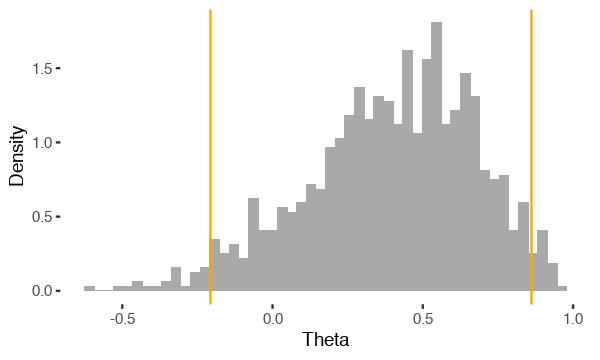

In [12]:
ggplot() +
    geom_histogram(data = thetas, aes(x=Theta, y = ..density..), fill="darkgrey", bins=50) +
    ggthemes::theme_tufte() +
    geom_vline(data = NULL, aes(xintercept = quants[1]), color="orange") +
    geom_vline(data = NULL, aes(xintercept = quants[3]), color="orange") +
    scale_y_continuous("Density")